In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Complete


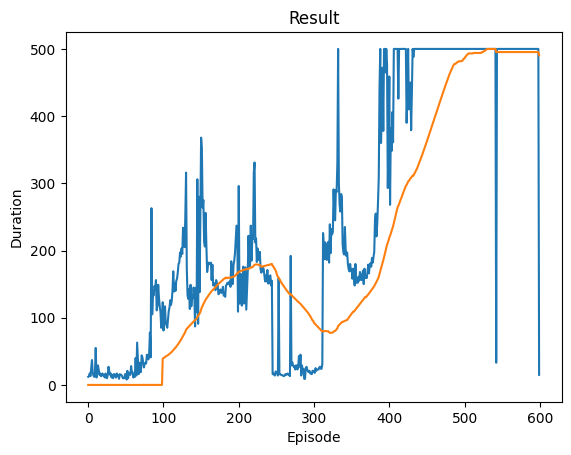

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
from DQN import DQNAgent

env = gym.make("CartPole-v1")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_episodes = 600
observation_space = env.observation_space
action_space = env.action_space
print(action_space.n)
# state, info = env.reset()
# print(len(state))
dqn_agent = DQNAgent(observation_space=observation_space, action_space=action_space)

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=dqn_agent.device).unsqueeze(0)
    dqn_agent.reset(state)
    
    for t in count():
        action = dqn_agent.act()
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=dqn_agent.device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=dqn_agent.device).unsqueeze(0)

        
        dqn_agent.replay_buffer.push(dqn_agent.s, action, next_state, reward)
        
        
        dqn_agent.observe(next_state, reward)

        # Move to the next state
        # state = next_state
        
        # Perform one step of the optimization (on the policy network)
        dqn_agent.learn()
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()